## Multi-label classification

Planet, satellite imaging competion. Some similarities to what we've seen before.  

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [16]:
from IPython.core.display import HTML
css_file = 'my_css.css'
HTML(open(css_file, "r").read())

In [3]:
from fastai.conv_learner import *

In [4]:
PATH = 'data/planet/'

In [ ]:
# Data preparation steps if you are using Crestle:

os.makedirs('data/planet/models', exist_ok=True)
os.makedirs('/cache/planet/tmp', exist_ok=True)

!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/test-jpg {PATH}
!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
!ln -s /cache/planet/tmp {PATH}

In [6]:
ls {PATH}

models/


## Multi-label versus single-label classification

- In single-label classification each sample belongs to one class. 
- In the previous example, binary, each image is either a dog or a cat.

In [11]:
from fastai.plots import *

In [12]:
def get_1st(path): return glob(f'{path}/*.*')[0]

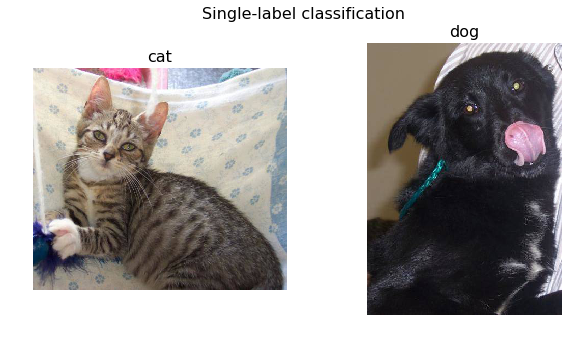

In [13]:

# either a cat or a dog

dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

### Planet Competition Satellite Data 

There are four types of weather including
- haze
- clear

Some Features include
Agriculture
Primary (rain forest)
River (river or creak)

We want to predict multiple things. So, Softmax is not good in this case. Softmax, wants to pick a thing. Often it is misued, it is kindof rediculus to use it for multilable competition. 

Fastai will look at labels. If there is more than one ever, it will switch into multi-label mode. 



FileNotFoundError: [Errno 2] No such file or directory: 'data/planet/train-jpg/train_0.jpg'

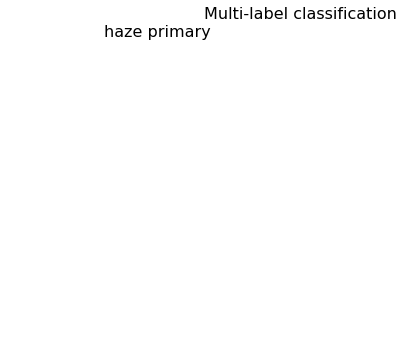

In [14]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more classes. In the previous example, the first images belongs to two classes: *haze* and *primary*. The second image belongs to four classes: *agriculture*, *clear*, *primary* and  *water*.

## 3  Multi-label models for Planet dataset

### CSV Files (from_csv)
If you have multilabel images (objects), then cant use the classic keras approach where each class is in a directory. You have to use a CSV approach. Things can't be in multiple folders at the same time.

### Output Activation for Multilabel
- activation is Sigmoid ... Fastai does this for you, by checking yoru data set looking for more than 1 label 
- similar to softmax ... 

<script>
    MathJax.Hub.Config({
        displayAlign: 'left'
    });
</script>

- Singlelable classification softmax
- Multilabel activation function sigmoid
   - each class activation goes through a sigmoid function ... don't add up the x's

$$  EQN \enspace 1 \hspace{3em} Sigmoid = f(x) =  \frac{e^x}{1 + e^{x}} = \frac{1}{1 + e^{-x}}$$

- asymptopes the top to 1
- asumptopes the bottom to 0
- This is what we use in logistic regression
- Sigmoid and Softmax are similar conceptually

<img src="./SigmoidFunction.png" style='width:500px;height:300px;'>



In [15]:
# metrics = f2
# recall the confusion matrix ... can turn it into a score
# f beta ... how much do you weight false negatives or false positives, how do you weight 
# function f beta how much do you weight beta, false negatives. f2 is f-beta with betat =  2, 
#   weight fase positives by 2
# Kaggle said they want to use f-beta metric
# Look inside courses/dl1 ... see planet.py ... 
#  function call f2 ... gets f beta score from scikit ... you can write any metric you'd like
#  takes in predictions and targets and you get back a number ... 
# below this number is printed as the last number in learn.sched.plot() ... 
from planet import f2

metrics=[f2]
f_model = resnet34

In [ ]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

### Eight possible symetries for square
- transforms below
- Dihedral group ... full set of eight rotations and flips
- Plus things you can do to cats and dogs zoomin, rotating, contrasting
- Dihederal group of eight - Rotatied 90 180 270 0 and for each of these flipped

- get_data 
  - ... give you mini batch of data objects ... has several embedded classes 
  - 256 x 256 images ... 
  - data object ... val_ds, test_ds, index into and grab image ... dl _ data loader ds - data set
  - concepts from PyTorch ... Google PyTorch data set
  - data loader gives you transformed mini-batch
  - can pass in transforms and processes ... 
  - get back the next mini-batch, grab a minibactch at a time
- Python and PyTorch
  - Python gives you iterator ... iterator, pass it to the Python next function, give me another batch
  - PyTorch leverages Pythons kind of stuff
  - TensorFlow invents its hold new world, but not a great fit to any platform
  - If you know Python well PyTorch comes naturally
  - PyTorch NN module is a standard Python class


In [ ]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [ ]:
data = get_data(256)

In [ ]:
x,y = next(iter(data.val_dl))

In [ ]:
# one mini-batch of lables
# batch size, by default 64
# Shift-tab see what you can apss
y
# 64 x 17 ... 17 of the possible classes


    1     0     0  ...      0     1     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
[torch.FloatTensor of size 64x17]

### on-hot encoded vectors
- behind the scenes, PyTorch and Fastai are turning our labels into one-hot encoding. 
- At the end of Octavio's video ... template had to match to A, B, C ... template. Doing a dot product, fully conntected layer going through a softmax compared to a 1 hot encoded labels. 
- we will talk about loss function next time
- Storing one-hot as lots of 0's and 1's is inefficient. Instead, we store the index value (for class of index) internall in PyTorch it will turn it into a 1-hot encoded vector. For example dogs competition just see indexes. Inside PyTorch will turn it into a 1-hot encoded vector. The same thing happens for single level computation.

In [ ]:
# show the classes on the first item (0-th item)... it may be agriculture and clear and primary
list(zip(data.classes, y[0]))

In [ ]:
# look at 
# zip takes 2 lists and combines, 
#  0-th item list 1, item 0-th list 2
#  1st  item list 1, 1-st item list 2
#   ...
list(zip(data.classes, y[0]))

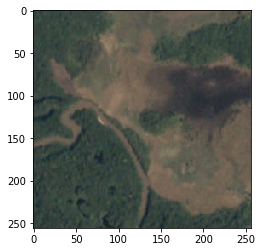

In [ ]:
# when first displayed this image it was washed out
# times 1.4 to make it more visible ... images are ust matrices of numbers
# it it looks washed out, then just multiply it times something to brighten
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [ ]:
# these images are not very much like imagenet
# things you will likely work on will not be like imagenet
# metal tubes, satellite imagery, ...
sz=64

In [ ]:
# start by resizing data to 64 x 64 
# cats and dogs starts almost perfect 
# ... if we did this would destroy weights
# on the otherhand nothing in imagenet that looks like satellites
# some of the early layers maybe ... edges ... 
# starting with small images works well for things like satellites

data = get_data(sz)

In [ ]:
# pass in a size when pass in images
# whatever is passed in ... transform above will transform
# resizing 64 x 64 will take more time than training
# will not be using images bigger than 1.3 x so resize ... will save lots of time ... 
data = data.resize(int(sz*1.3), 'tmp')

A Jupyter Widget

In [ ]:
# built model
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

A Jupyter Widget

[ 0.       0.22404  0.31176  0.82044]                        



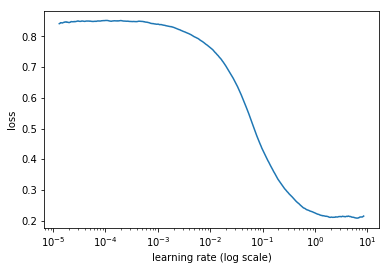

In [ ]:
# find learning rate
# turns out high
lrf=learn.lr_find()
learn.sched.plot()

In [ ]:
# lr turned out to be high
lr = 0.2

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.14882  0.13552  0.87878]                        
[ 1.       0.14237  0.13048  0.88251]                        
[ 2.       0.13675  0.12779  0.88796]                        
[ 3.       0.13528  0.12834  0.88419]                        
[ 4.       0.13428  0.12581  0.88879]                        
[ 5.       0.13237  0.12361  0.89141]                        
[ 6.       0.13179  0.12472  0.8896 ]                        



In [ ]:
# initial layer divide by 9, middle divide by 3
# earlier layers not as close compared to imagenet
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
# unfreeze and train for a while
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.12534  0.10926  0.90892]                        
[ 1.       0.12035  0.10086  0.91635]                        
[ 2.       0.11001  0.09792  0.91894]                        
[ 3.       0.1144   0.09972  0.91748]                        
[ 4.       0.11055  0.09617  0.92016]                        
[ 5.       0.10348  0.0935   0.92267]                        
[ 6.       0.10502  0.09345  0.92281]                        



In [ ]:
learn.save(f'{sz}')

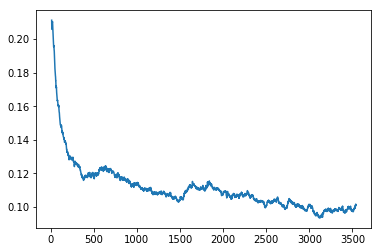

In [ ]:

learn.sched.plot_loss()

In [ ]:
# increase size
sz=128

In [ ]:
# fit for a while
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.09729  0.09375  0.91885]                         
[ 1.       0.10118  0.09243  0.92075]                         
[ 2.       0.09805  0.09143  0.92235]                         
[ 3.       0.09834  0.09134  0.92263]                         
[ 4.       0.096    0.09046  0.9231 ]                         
[ 5.       0.09584  0.09035  0.92403]                         
[ 6.       0.09262  0.09059  0.92358]                         



In [ ]:
# unfreeze
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

A Jupyter Widget

[ 0.       0.09623  0.08693  0.92696]                         
[ 1.       0.09371  0.08621  0.92887]                         
[ 2.       0.08919  0.08296  0.93113]                         
[ 3.       0.09221  0.08579  0.92709]                         
[ 4.       0.08994  0.08575  0.92862]                         
[ 5.       0.08729  0.08248  0.93108]                         
[ 6.       0.08218  0.08315  0.92971]                         



In [ ]:
# increase image size again 
sz=256

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.09161  0.08651  0.92712]                         
[ 1.       0.08933  0.08665  0.92677]                         
[ 2.       0.09125  0.08584  0.92719]                         
[ 3.       0.08732  0.08532  0.92812]                         
[ 4.       0.08736  0.08479  0.92854]                         
[ 5.       0.08807  0.08471  0.92835]                         
[ 6.       0.08942  0.08448  0.9289 ]                         



In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

A Jupyter Widget

[ 0.       0.08932  0.08218  0.9324 ]                         
[ 1.       0.08654  0.08195  0.93313]                         
[ 2.       0.08468  0.08024  0.93391]                         
[ 3.       0.08596  0.08141  0.93287]                         
[ 4.       0.08211  0.08152  0.93401]                         
[ 5.       0.07971  0.08001  0.93377]                         
[ 6.       0.07928  0.0792   0.93554]                         



In [ ]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [ ]:
f2(preds,y)

0.93626519738612801

### End